In [1]:
import numpy as np
import scipy.io as sio
import scipy.linalg as slinalg
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append("../")
import ICP
import importlib
from PDE2D import *
from Mahalanobis import *
from Kuramoto import *
from DiffusionMaps import *
import Mahalanobis
from LocalPCA import *
from ripser import ripser
from persim import plot_diagrams as plot_dgms

In [2]:
np.random.seed(1)

theta1 = 0
theta2 = np.pi/2
fac = 0.5
Win = 100
pd1 = (Win, 1)
pd2 = (Win, 1)
N = 7500
cropheight = 330 #195


delta = 3
n_points = 100
rank = 2
pca_dim = 120
maxeigs = 90
dMaxSqr = 1000


ks1 = KSSimulation(co_rotating=False, scale=(fac*10, fac/1.42), reldir='../')
ks1.crop(0, cropheight, 0, ks1.I.shape[1])
ks1.makeObservations(pd1, N)
ks1.thetas[0:N] = theta1
ks1.completeObservations()
ks1.resort_byraster()

ks2 = KSSimulation(co_rotating=False, scale=(fac*10, fac/1.42), reldir='../')
ks2.crop(0, cropheight, 0, ks2.I.shape[1])
ks2.makeObservations(pd2, N)
ks2.thetas[0:N] = theta2
ks2.completeObservations()
ks2.resort_byraster()

pdes = [ks1, ks2]
for ks in pdes:
    if pca_dim < ks.patches.shape[1]:
        ks.compose_with_dimreduction(dim=pca_dim)

Making 7500 observations of dimension (100, 1) on a grid of (330, 140)...
Elapsed time patch sampling: 0.211
Elapsed time patch sampling: 0.197
Making 7500 observations of dimension (100, 1) on a grid of (330, 140)...
Elapsed time patch sampling: 0.208
Elapsed time patch sampling: 0.194


(7500, 100)
Computing Jacobians, rank = 2, maxiegs = 90...
0 of 7500
500 of 7500
1000 of 7500
1500 of 7500
2000 of 7500
2500 of 7500
3000 of 7500
3500 of 7500
4000 of 7500
4500 of 7500
5000 of 7500
5500 of 7500
6000 of 7500
6500 of 7500
7000 of 7500
Elapsed Time: 34.6
Computing Mahalanobis Distances...
Elapsed Time: 216
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 Elapsed Time: 422
(7500, 100)
Computing Jacobians, rank = 2, maxiegs = 90...
0 of 7500
500 of 7500
1000 of 7500
1500 of 7500
2000 of 7500
2500 of 7500
3000 of 7500
3500 of 7500
4000 of 7500
4500 of 7500
5000 of 7500
5500 of 7500
6000 of 7500
6500 of 7500
7000 of 7500
Elapsed Time: 36.2
Computing Mahalanobis Distances...
Elapsed Time: 211
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 Elapsed Time: 416


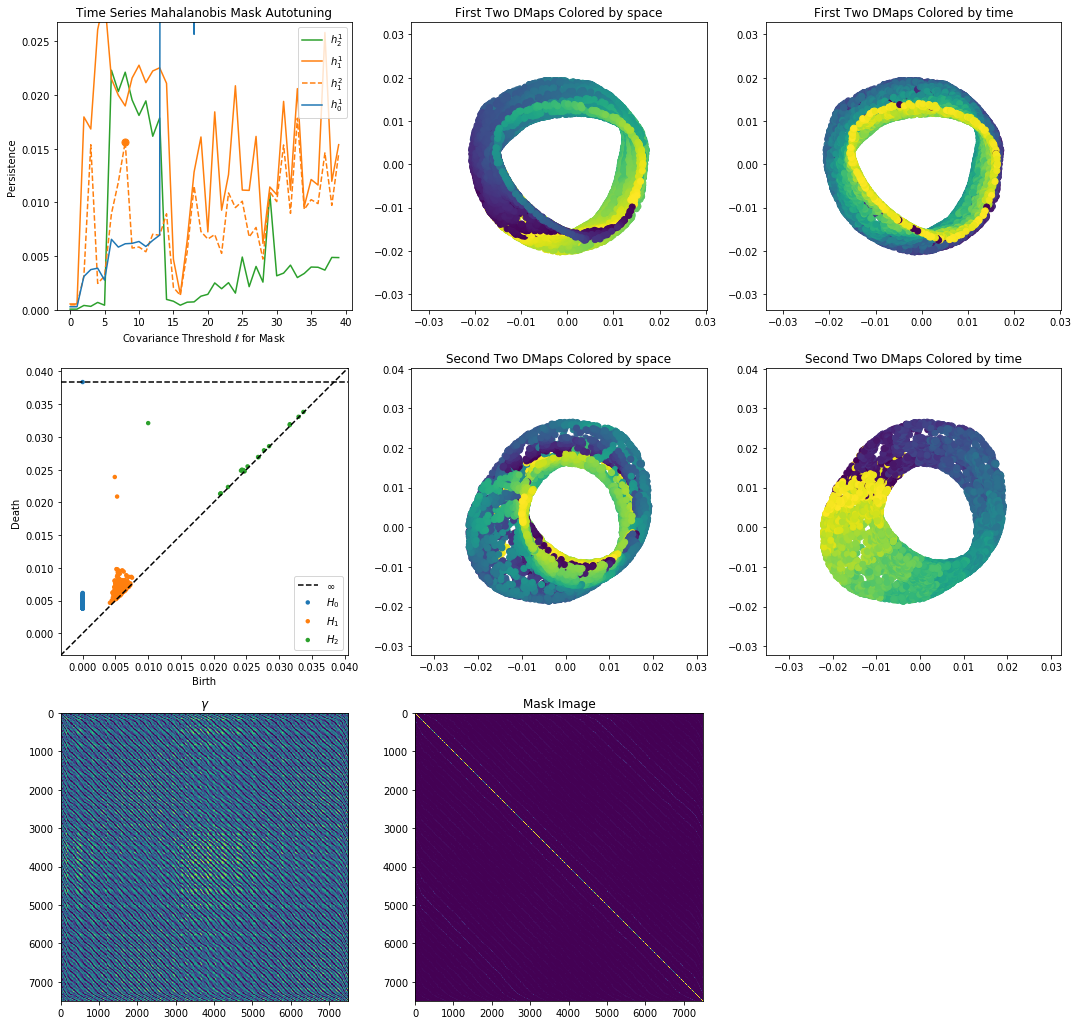

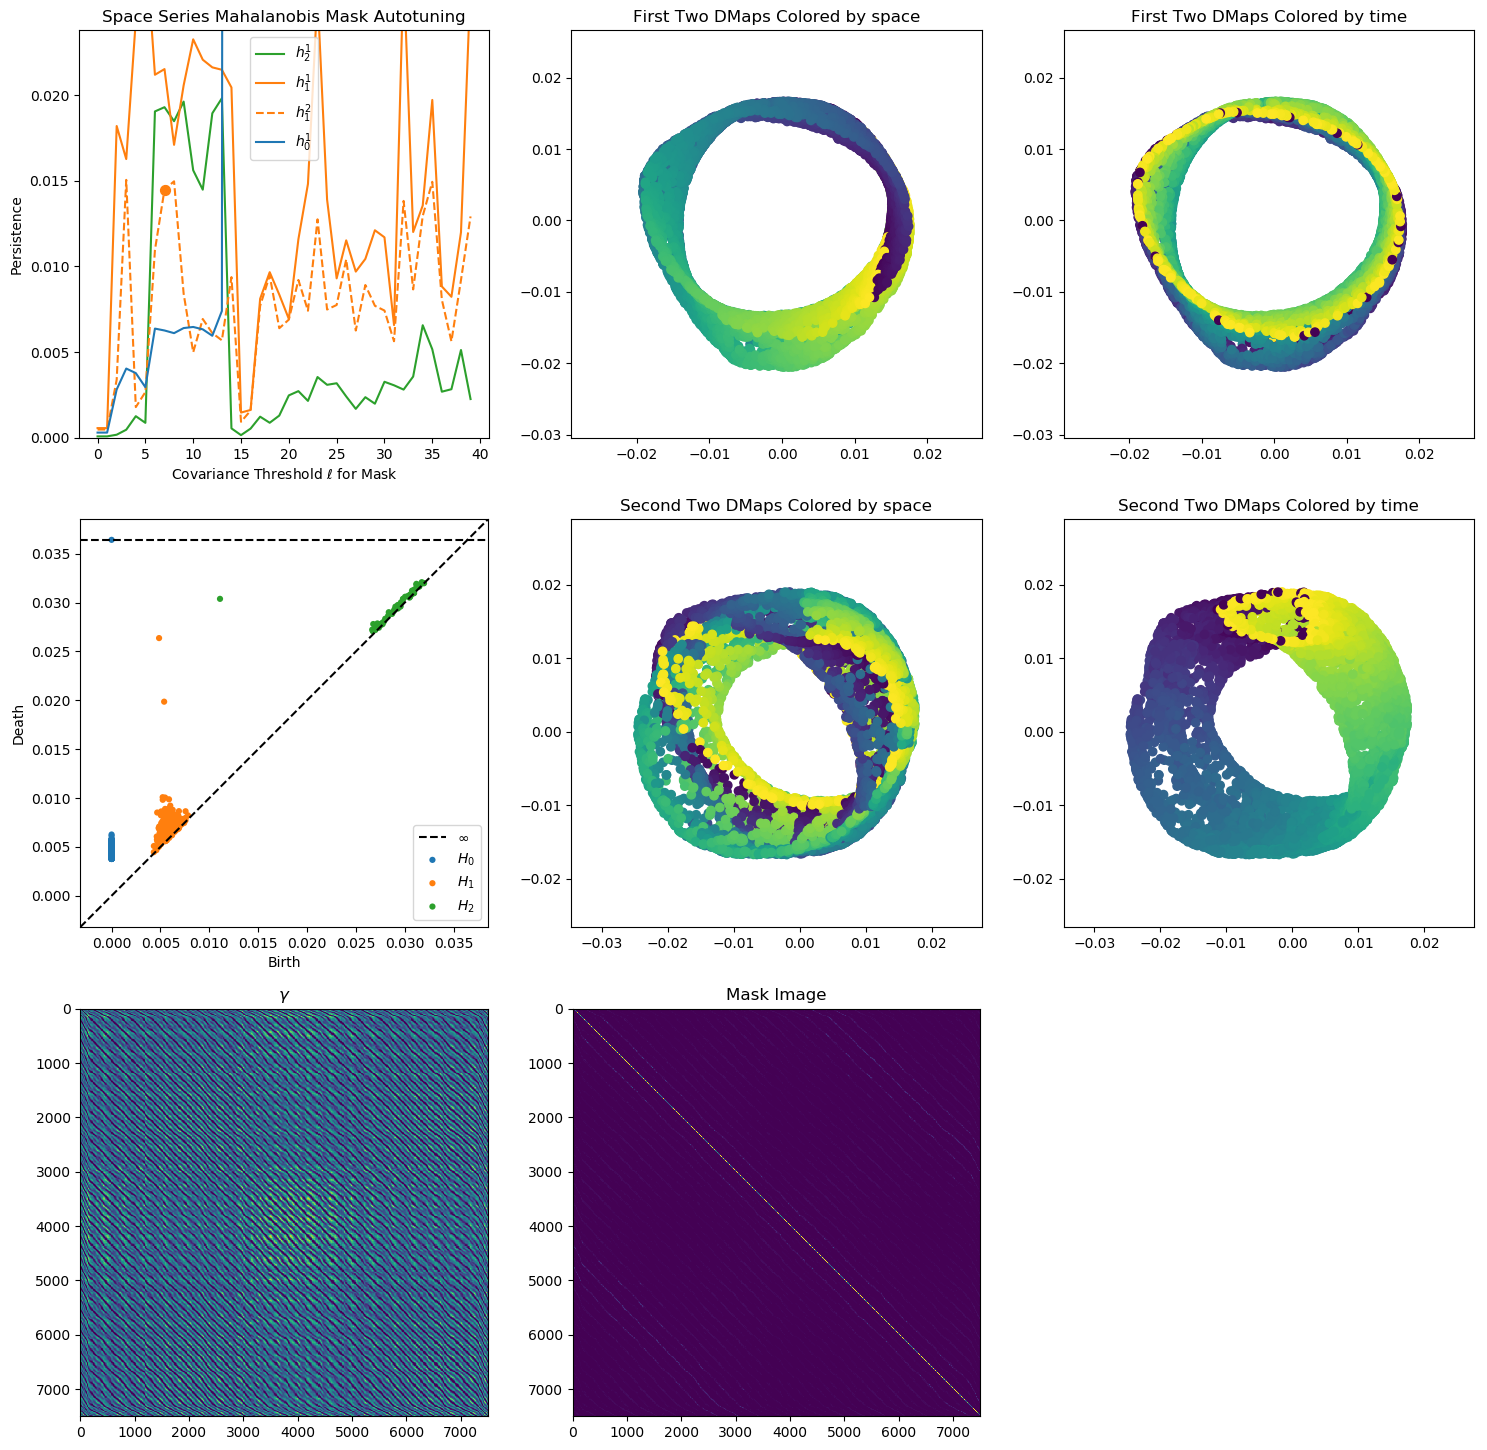

In [3]:
## Perform diffusion maps on each set individually
labels = ["Time Series", "Space Series"]
Ys = []
alldgms = []
allgamma = []
allmaskidx = []
for i in range(2):
    plt.figure(figsize=(18, 18))
    ksi = pdes[i]
    print(ksi.patches.shape)
    ellipsoid_fn = lambda idx, delta, n_points: ks.get_mahalanobis_ellipsoid(idx, delta, n_points, uniform_circle=True)
    res = Mahalanobis.getMahalanobisDists(ks.patches, ellipsoid_fn, delta, n_points=n_points, rank=rank, maxeigs=maxeigs)
    gamma, maskidx = res["gamma"], res["maskidx"]
    allgamma.append(gamma)
    allmaskidx.append(maskidx)
    eps = dMaxSqr*np.max(gamma)*1e-3 # Autotune diffusion eps in terms of point cloud diameter
    # Try different thresholds of the Mahalanobis mask
    res = getMahalanobisAllThresh(gamma, maskidx, eps=eps, maxthresh=40, verbose=True)
    alldgmsi, Ysi = res["alldgms"], res["Ys"]
    plt.subplot(331)
    scores = getTorusPersistenceScores(alldgmsi, do_plot=True)["scores"]
    idx = np.argmax(scores)
    Ys.append(Ysi[idx])
    alldgms.append(alldgmsi[idx])
    plt.title("%s Mahalanobis Mask Autotuning"%labels[i])
    plt.subplot(334)
    plot_dgms(alldgms[i])
    plt.subplot(332)
    plt.scatter(Ys[i][:, 0], Ys[i][:, 1], c=ksi.xcoords)
    plt.title("First Two DMaps Colored by space")
    plt.subplot(333)
    plt.scatter(Ys[i][:, 0], Ys[i][:, 1], c=ksi.tcoords)
    plt.title("First Two DMaps Colored by time")
    plt.subplot(335)
    plt.scatter(Ys[i][:, 2], Ys[i][:, 3], c=ksi.xcoords)
    plt.title("Second Two DMaps Colored by space")
    plt.subplot(336)
    plt.scatter(Ys[i][:, 2], Ys[i][:, 3], c=ksi.tcoords)
    plt.title("Second Two DMaps Colored by time")
    plt.subplot(337)
    plt.imshow(allgamma[i])
    plt.title("$\\gamma$")
    plt.subplot(338)
    plt.imshow(allmaskidx[i])
    plt.title("Mask Image")

In [ ]:
## Align the two patch sets using some correspondences
importlib.reload(ICP)

for seed in [9]:
    np.random.seed(seed)
    ncorresp = 4
    x1 = np.array([pdes[0].Xs, pdes[0].Ts])
    x2 = np.array([pdes[1].Xs, pdes[1].Ts])
    D = ICP.getCSM(x1, x2)
    D = np.argmin(D, 1)
    idx = np.random.permutation(np.arange(Ys[0].shape[0]))[0:ncorresp]
    corresp = np.zeros((ncorresp, 2), dtype=int)
    corresp[:, 0] = idx
    corresp[:, 1] = D[idx]
    weights = np.ones(Ys[0].shape[0])
    weights[idx] = 5000

    print(seed)
    idxMin = ICP.doICP_PDE2D(pdes[0], Ys[0][:, 0:4], pdes[1], Ys[1][:, 0:4], corresp=corresp, weights=weights, \
                             initial_guesses=1, do_plot=False, MaxIters=200)['idxMin']

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(x1[0, :], x2[0, idxMin[-1]])
    plt.subplot(122)
    plt.scatter(x1[1, :], x2[1, idxMin[-1]])

9
rmse=0.193


In [ ]:
pdes[1].f_patch = lambda x: x
pdes[1].completeObservations()

In [ ]:
import matplotlib.transforms as mtransforms

plt.figure(figsize=(15, 10))
## Subplot 1: Shuffled line segments on the left, patches on the right

vmax = np.max(np.abs(pdes[0].I))
vmin = -vmax
ax = plt.subplot(231)
N = 40
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
#idxs, _ = getGreedyPerm(locs, N)
idxs = np.random.permutation(locs.shape[0])
locs = locs[idxs, :]
idxs = np.random.permutation(pdes[0].Xs.size)

for i in range(N):
    p = np.reshape(pdes[0].patches[idxs[i], :], pdes[0].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([0, 100])
plt.ylim([200, 10])
plt.axis('off')
plt.title("Shuffled %s"%labels[1])


ax = plt.subplot(232)
locs = np.array([pdes[0].Xs, pdes[0].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs = np.random.permutation(locs.shape[0])
locs = locs[idxs, :]
print(locs.shape)
locs -= np.mean(locs, 0)
idxs = np.random.permutation(pdes[1].Xs.size)
for i in range(N):
    p = np.reshape(pdes[1].patches[idxs[i], :], pdes[1].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = np.array(locs[i, :])
    u[1] *= 2
    m[0:2, 2] = u
    c = np.cos(pdes[1].thetas[i])
    s = np.sin(pdes[1].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([-50, 150])
plt.ylim([80, -80])
plt.axis('off')
plt.title("Shuffled %s"%labels[0])

locs = np.array([pdes[0].Xs, pdes[0].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs, _ = getGreedyPerm(locs, N)
locs = locs[idxs, :]
ax = plt.subplot(234)
for i in range(corresp.shape[0]):
    i1, i2 = corresp[i, :]
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    # Draw line segment type 1
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    c = np.cos(pdes[1].thetas[i])
    s = np.sin(pdes[1].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
    
    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
plt.xlim([-90, 150])
plt.ylim([160, -80])
plt.axis('off')
plt.title("Given correspondences")

ax = plt.subplot(235)
N = 20
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
#idxs, _ = getGreedyPerm(locs, N)
idxs = np.random.permutation(locs.shape[0])
correspfinal = idxMin[-1]
for i1 in idxs[0:N]:
    i2 = correspfinal[i1]
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    # Draw line segment type 1
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i1, :]
    c = np.cos(pdes[1].thetas[i])
    s = np.sin(pdes[1].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)

for i1 in idxs[0:N]:
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i1, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
    
plt.xlim([-75, 150])
plt.ylim([240, -10])
plt.axis('off')
plt.title("Expanded Correspondence Set")


plt.subplot(236)
f_interp = pdes[0].getInterpolator()
patch_centers = f_interp(pdes[0].Ts.flatten(), pdes[0].Xs.flatten(), grid=False)
plt.scatter(pdes[1].Xs[correspfinal], pdes[1].Ts[correspfinal], c=patch_centers, cmap='RdGy', vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.axis('off')
plt.title("%s Positions\nColored by %s centers"%tuple(labels))

plt.savefig("HorizontalToVerticalAligned.svg", bbox_inches='tight')